In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

RSEED = 42

In [3]:
# Load data
df = pd.read_csv("../data/preprocessed/Building_5.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

In [22]:
# Add a total load with cooling
df['total_load_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh'] + df['cooling_load_kWh']

# Add a total load without cooling
df['total_load_wo_cooling_kWh'] = df['equipment_electric_power_kWh'] + df['dhw_heating_kWh']

# Replace holiday and workday with 0 or 1
df['holiday'] = df['holiday'].replace({True: 1, False: 0})
df['workday'] = df['workday'].replace({True: 1, False: 0})
df['daylight_savings'] = df['daylight_savings'].replace({True: 1, False: 0})


#df['month'] = df['month'].astype('category')
#df['hour'] = df['hour'].astype('category')

df.columns

# df = df.drop('day_type', axis=1)
# df = pd.get_dummies(df, drop_first=True)

df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)

In [23]:
df.columns

Index(['month', 'hour', 'daylight_savings', 'indoor_temp',
       'avg_unmet_cooling_temp', 'indoor_hum', 'equipment_electric_power_kWh',
       'dhw_heating_kWh', 'cooling_load_kWh', 'solar_generation_W_kW',
       'outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2',
       'direct_solar_W_m2', 'pred_6h_outdoor_temp', 'pred_12h_outdoor_temp',
       'pred_24h_outdoor_temp', 'pred_6h_outdoor_hum', 'pred_12h_outdoor_hum',
       'pred_24h_outdoor_hum', 'pred_6h_diffuse_solar_W_m2',
       'pred_12h_diffuse_solar_W_m2', 'pred_24h_diffuse_solar_W_m2',
       'pred_6h_direct_solar_W_m2', 'pred_12h_direct_solar_W_m2',
       'pred_24h_direct_solar_W_m2', 'holiday', 'workday',
       'solar_generation_kW', 'total_load_kWh', 'total_load_wo_cooling_kWh',
       'pred_24h_diffuse_solar_W_m2_shift',
       'pred_24h_direct_solar_W_m2_shift'],
      dtype='object')

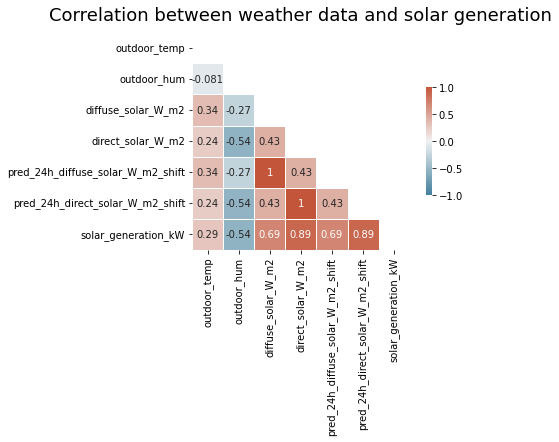

In [25]:
# correlation matrix for weather data + solar generation
corr_weather= df[['outdoor_temp','outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2', 'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift', 'solar_generation_kW']].corr()
mask = np.triu(np.ones_like(corr_weather, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(corr_weather, mask=mask, cmap=cmap, vmax=1, vmin=-1,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
heatmap.set_title('Correlation between weather data and solar generation', fontdict={'fontsize':18}, pad=12);
#sns.heatmap(corr_weather, vmin=-1, vmax=1, annot=True)

<AxesSubplot:xlabel='datetime'>

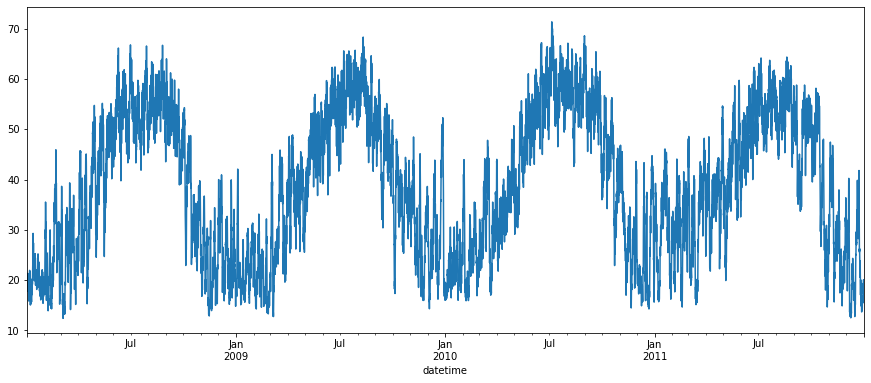

In [7]:
fig, ax = plt.subplots(figsize=(15,6))
#df_plot = df[df.index.year == 2008]
df['total_load_kWh'].rolling(30).mean().plot()

<AxesSubplot:xlabel='datetime'>

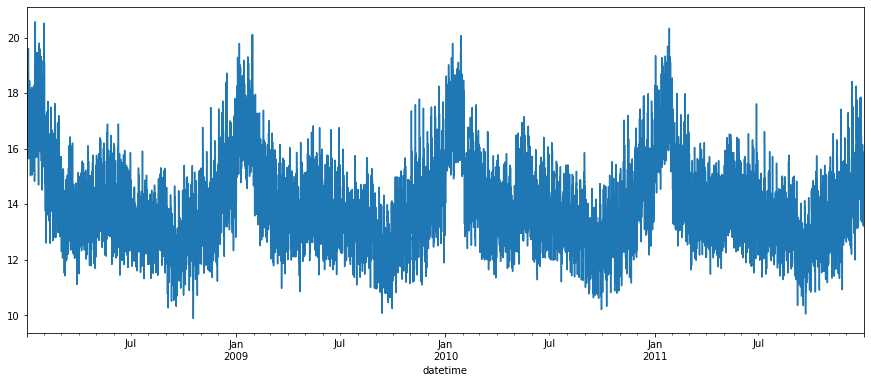

In [8]:
fig, ax = plt.subplots(figsize=(15,6))
#df_plot = df[df.index.year == 2008]
df['total_load_wo_cooling_kWh'].rolling(30).mean().plot()

<AxesSubplot:xlabel='datetime'>

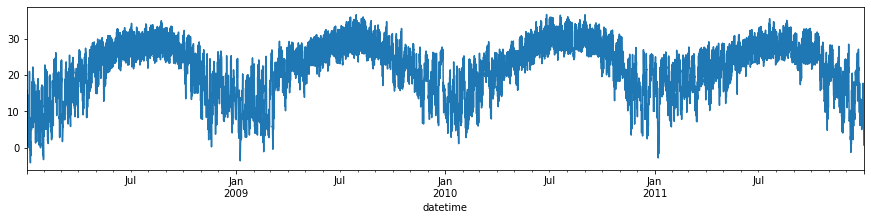

In [9]:
fig, ax = plt.subplots(figsize=(15,3))
df['outdoor_temp'].plot()

<AxesSubplot:>

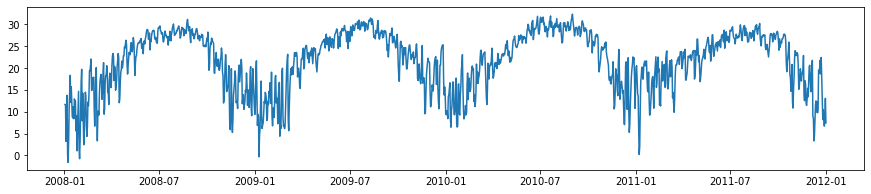

In [10]:
df_day = df.groupby(df.index.date).mean()
fig, ax = plt.subplots(figsize=(15,3))
df_day['outdoor_temp'].plot()

<AxesSubplot:>

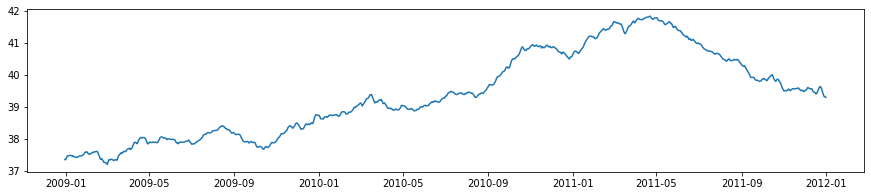

In [11]:
fig, ax = plt.subplots(figsize=(15,3))
df_day['total_load_kWh'].rolling(365).mean().plot()

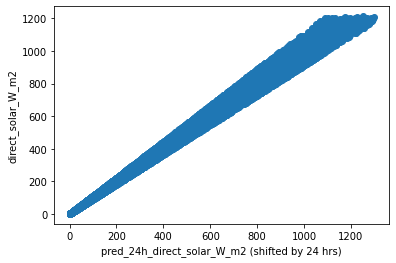

In [12]:
plt.scatter(df['pred_24h_direct_solar_W_m2'].shift(periods=24), df['direct_solar_W_m2'])
plt.xlabel('pred_24h_direct_solar_W_m2 (shifted by 24 hrs)')
plt.ylabel('direct_solar_W_m2')
plt.show()


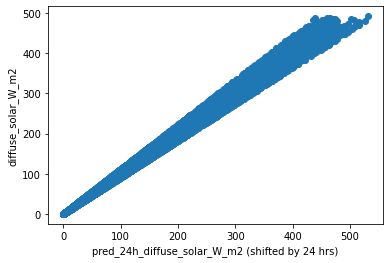

In [13]:
plt.scatter(df['pred_24h_diffuse_solar_W_m2'].shift(periods=24), df['diffuse_solar_W_m2'])
plt.xlabel('pred_24h_diffuse_solar_W_m2 (shifted by 24 hrs)')
plt.ylabel('diffuse_solar_W_m2')
plt.show()


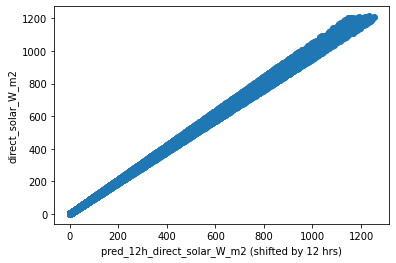

In [14]:
plt.scatter(df['pred_12h_direct_solar_W_m2'].shift(periods=12), df['direct_solar_W_m2'])
plt.xlabel('pred_12h_direct_solar_W_m2 (shifted by 12 hrs)')
plt.ylabel('direct_solar_W_m2')
plt.show()


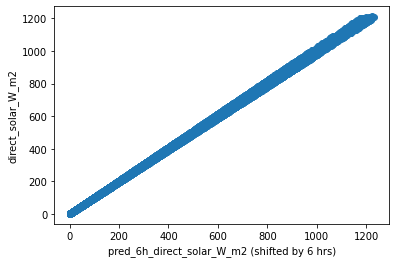

In [15]:
plt.scatter(df['pred_6h_direct_solar_W_m2'].shift(periods=6), df['direct_solar_W_m2'])
plt.xlabel('pred_6h_direct_solar_W_m2 (shifted by 6 hrs)')
plt.ylabel('direct_solar_W_m2')
plt.show()


In [16]:
df[['outdoor_temp','direct_solar_W_m2','solar_generation_kW','pred_24h_direct_solar_W_m2_shift','diffuse_solar_W_m2']].corr()

KeyError: "['pred_24h_direct_solar_W_m2_shift'] not in index"

In [ ]:
correlation = df['pred_24h_direct_solar_W_m2_diff'].corr(df['solar_generation_W_kW_diff'])
correlation

In [ ]:
X = df[['month']]
y = df['outdoor_temp']

lin_reg = LinearRegression()
lin_reg.fit(X, y)
intercept = lin_reg.intercept_
slope = lin_reg.coef_[0]

y_pred = lin_reg.predict(X)
print("R-squared:", r2_score(y, y_pred).round(3))

In [ ]:
#X = df[['outdoor_temp','outdoor_hum']]
X = df.drop()
y = df['solar_generation_W_kW']

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)

poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)

y_pred = poly_reg_model.predict(poly_features)

#plt.figure(figsize=(10, 6))
#plt.title("Your first polynomial regression – congrats! :)", size=16)
#plt.scatter(X, y)
#plt.scatter(X, y_pred, c="red")
#plt.show()
print("R-squared:", r2_score(y, y_pred).round(3))